In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import math
import seaborn as sns

sns.set_theme()

In [2]:
ene = 4.2
ene_str = str(ene).replace('.', '_')

In [3]:
import ROOT

# Open the .root file
file = ROOT.TFile("test1_2.root")

# Iterate over all items in the file
for key in file.GetListOfKeys():
    obj = key.ReadObj()
    # Check if the object is a tree
    if isinstance(obj, ROOT.TTree):
        tree_name = obj.GetName()
        print(f"Tree: {tree_name}")
        
        # List all branches in the tree
        branches = obj.GetListOfBranches()
        for branch in branches:
            print(f"  Branch: {branch.GetName()}")


Welcome to JupyROOT 6.30/04
Tree: PrimaryParticle
  Branch: energyPrimary
  Branch: eventNumber
Tree: Detectors
  Branch: detectorPositionX
  Branch: detectorPositionY
  Branch: eventNumber
  Branch: trackID
Tree: CircleCenter
  Branch: centerX
  Branch: centerY
  Branch: eventNumber


In [ ]:
# Access the 'Detectors' tree
tree = file.Get("Detectors")

# Define the branches you want to extract
branches = ['detectorPositionX', 'detectorPositionY', 'eventNumber']

# Determine the total number of entries
total_entries = tree.GetEntries()

# Define the chunk size
chunk_size = 15000000 # Adjust based on your system's RAM

# Initialize a list for the chunk DataFrames
dfs = []

# Process the tree in chunks
for start in range(0, total_entries, chunk_size):
    end = min(start + chunk_size, total_entries)
    data_list = []

    # Loop over the entries in the current chunk
    for i in range(start, end):
        tree.GetEntry(i)
        # Access branch data directly
        data = {branch: getattr(tree, branch) for branch in branches}
        data_list.append(data)

    # Convert the chunk to a DataFrame
    chunk_df = pd.DataFrame(data_list)

    # Convert the 'eventNumber' column to int32
    chunk_df['eventNumber'] = chunk_df['eventNumber'].astype('int32')

    # Add the chunk DataFrame to the list
    dfs.append(chunk_df)

    # Delete the data list to free up memory
    del data_list

    # Force the garbage collector to release unreferenced memory
    gc.collect()

# Concatenate all chunk DataFrames
df = pd.concat(dfs, ignore_index=True)


In [ ]:
# Now, drop the duplicates
df = df.drop_duplicates(subset=['eventNumber', 'detectorPositionX', 'detectorPositionY'])

gc.collect()

In [ ]:
# Group by 'eventNumber' and filter out groups with less than 3 elements
df = df.groupby('eventNumber').filter(lambda x: len(x) >= 4)# Calculate group sizes
group_sizes = df.groupby('eventNumber').size()

# Filter out groups with less than 3 elements
df = df[df['eventNumber'].isin(group_sizes[group_sizes >= 3].index)]

In [ ]:
# Access the 'PrimaryParticle' tree
tree1 = file.Get("PrimaryParticle")

# Define the branches you want to extract from the 'PrimaryParticle' tree
branches1 = ['energyPrimary', 'eventNumber']

# Determine the total number of entries in the 'PrimaryParticle' tree
total_entries1 = tree1.GetEntries()

# Initialize an empty DataFrame for the final result
df1 = pd.DataFrame()

for start in range(0, total_entries1, chunk_size):
    end = min(start + chunk_size, total_entries1)
    data_list1 = []

    # Loop over the entries in the current chunk
    for i in range(start, end):
        tree1.GetEntry(i)
        # Access branch data directly
        data1 = {branch: getattr(tree1, branch) for branch in branches1}
        data_list1.append(data1)

    # Convert the chunk to a DataFrame
    chunk_df1 = pd.DataFrame(data_list1)

    # Divide the 'energyPrimary' column by 1000 and convert to float16
    chunk_df1['energyPrimary'] = (chunk_df1['energyPrimary'] / 1000)
    chunk_df1['eventNumber'] = chunk_df1['eventNumber'].astype('int32')

    # Append the chunk DataFrame to the main DataFrame
    df1 = pd.concat([df1, chunk_df1], ignore_index=True)

    # Delete the chunk DataFrame and the data list to free up memory
    del chunk_df1
    del data_list1

    # Force the garbage collector to release unreferenced memory
    gc.collect()

In [7]:
# Access the 'CircleCenter' tree
tree = file.Get("CircleCenter")

# Define the branches you want to extract
branches = ['centerX', 'centerY', 'eventNumber']

# Determine the total number of entries
total_entries = tree.GetEntries()

# Define the chunk size
chunk_size = 15000000 # Adjust based on your system's RAM

# Initialize an empty DataFrame for the final result
df2 = pd.DataFrame()

# Process the tree in chunks
for start in range(0, total_entries, chunk_size):
    end = min(start + chunk_size, total_entries)
    data_list = []

    # Loop over the entries in the current chunk
    for i in range(start, end):
        tree.GetEntry(i)
        # Access branch data directly
        data = {branch: getattr(tree, branch) for branch in branches}
        data_list.append(data)

    # Convert the chunk to a DataFrame
    chunk_df2 = pd.DataFrame(data_list)

    chunk_df2['centerX'] = chunk_df2['centerX']
    chunk_df2['centerY'] = chunk_df2['centerY']

    # Append the chunk DataFrame to the main DataFrame
    df2 = pd.concat([df2, chunk_df2], ignore_index=True)

    # Delete the chunk DataFrame and the data list to free up memory
    del chunk_df2
    del data_list

    # Force the garbage collector to release unreferenced memory
    gc.collect()

In [ ]:
df1 = df1[df1['eventNumber'].isin(df['eventNumber'])]
df = df[df['eventNumber'].isin(df2['eventNumber'])]
gc.collect()

In [ ]:
# Merge df with df1 on 'eventNumber', keeping only 'energyprimary' from df1
df = df.merge(df1[['eventNumber', 'energyPrimary']], on='eventNumber', how='left')

del df1
gc.collect()

In [10]:
"""# Filter the DataFrame for a specific eventNumber
event_number = df["eventNumber"].max() 	 	  # replace with your desired event number
df_event = df[df['eventNumber'] == event_number]

# Create a scatter plot of detectorPositionX and detectorPositionY
plt.scatter(df_event['detectorPositionX'], df_event['detectorPositionY'])

# Set the labels for the x and y axes
plt.xlabel('detectorPositionX')
plt.ylabel('detectorPositionY')

# Show the plot
plt.show()"""

'# Filter the DataFrame for a specific eventNumber\nevent_number = df["eventNumber"].max() \t \t  # replace with your desired event number\ndf_event = df[df[\'eventNumber\'] == event_number]\n\n# Create a scatter plot of detectorPositionX and detectorPositionY\nplt.scatter(df_event[\'detectorPositionX\'], df_event[\'detectorPositionY\'])\n\n# Set the labels for the x and y axes\nplt.xlabel(\'detectorPositionX\')\nplt.ylabel(\'detectorPositionY\')\n\n# Show the plot\nplt.show()'

In [ ]:
import joblib

# In the second notebook
poly_funcs = joblib.load('poly_funcs.pkl')

In [ ]:
from scipy.stats import norm

def gaussian(x, A, mu, sigma, x0):
    return A * np.where(x < x0, norm.pdf(x, mu, sigma) / norm.pdf(mu, mu, sigma), 0)

def powerlaw1(x, a1, k1, x0):
    return (a1 * ((x) / (x0 + 1e-5)) ** -k1)

def combined_function(x, a1, k1, A, mu, sigma, x0):
    return np.where(x < x0, gaussian(x, A, mu, sigma, x0), powerlaw1(x, a1, k1, x0))

def create_combined_function(energy, poly_funcs):
    # Get the parameters from the polynomial functions
    a1 = 0.00033
    k1 = poly_funcs['k1'](energy)
    x0 = poly_funcs['x0'](energy)
    A = poly_funcs['A'](energy)
    mu = 9
    sigma = poly_funcs['sigma'](energy)

    def combined_function(x):
        return np.where(x < x0, gaussian(x, A, mu, sigma, x0), np.where(x <= 600, powerlaw1(x, a1, k1, x0), 0))
    return combined_function

In [ ]:
from scipy.optimize import minimize
import sys
import multiprocessing as mp

def create_wrapper_function(ene):
    def negative_log_likelihood(params, x, y):
        a, b, r = params
        ri = np.sqrt((x - a)**2 + (y - b)**2) - r
        with np.errstate(invalid='ignore'):
            combined_function = create_combined_function(ene, poly_funcs)
            probabilities = combined_function(ri)
        # Avoid taking the log of zero by adding a small number epsilon
        epsilon = sys.float_info.epsilon
        nll = -np.sum(np.log(probabilities + epsilon))
        return nll
    return negative_log_likelihood

negative_log_likelihood = create_wrapper_function(ene)

def process_event(event):
    # Filter the DataFrame for the current event
    event_data = df[df['eventNumber'] == event]
    
    ene_value = event_data["energyPrimary"].unique()[0]  # Replace with your actual energy value
    #negative_log_likelihood = create_wrapper_function(ene_value)

    # Check if the event exists in df2
    if event in df2['eventNumber'].values:
        # Get the "real center" for the current event from df2
        real_center = df2[df2['eventNumber'] == event][['centerX', 'centerY']].values[0]
        
        # Initial guess for the circle's radius (r)
        initial_guess_r = np.sqrt(np.mean((event_data['detectorPositionX'] - real_center[0])**2 +
                                          (event_data['detectorPositionY'] - real_center[1])**2))
        initial_guess = [real_center[0], real_center[1], initial_guess_r]

        # Minimize the negative log-likelihood
        result = minimize(
            negative_log_likelihood,
            initial_guess,
            args=(event_data['detectorPositionX'].values,
                  event_data['detectorPositionY'].values),
            method='L-BFGS-B',
            bounds=[(-650, 650), (-650, 650), (15, 1840)],
            options={'ftol':1e-2, 'gtol':1e-2, 'maxiter':1000}
        )

        # Check if the optimization was successful
        if result.success:
            # Return the optimized parameters along with the event number
            return {
                'eventNumber': event,
                'centerX': result.x[0],
                'centerY': result.x[1],
                'radius': result.x[2]
            }

# Get unique event numbers
unique_events = df['eventNumber'].unique()

# Create a pool of workers
with mp.Pool(mp.cpu_count()) as pool:
    # Process each event in parallel
    optimized_params_list = pool.map(process_event, unique_events)

# Filter out None results
optimized_params_list = [x for x in optimized_params_list if x is not None]

# Create a DataFrame from the list of optimized parameters
optimized_params_df = pd.DataFrame(optimized_params_list)

del df2
gc.collect()

In [14]:
df = pd.merge(df, optimized_params_df, on='eventNumber', how='left', suffixes=('', '_new'))

df.rename(columns={'centerX_new': 'centerX', 'centerY_new': 'centerY'}, inplace=True)

del optimized_params_df
gc.collect()

0

In [15]:
# Convert columns back to float16
df['eventNumber'] = df['eventNumber'].astype('int32')
df['detectorPositionX'] = df['detectorPositionX'].astype('float16')
df['detectorPositionY'] = df['detectorPositionY'].astype('float16')

gc.collect()

0

In [ ]:
from scipy.optimize import fsolve

# Define the function
def calculate_half_angle(R, theta0=0.7):    
    def func(theta, R1=R, n=1.05, h=90, L=765):
        return L * np.tan(np.arcsin(n * np.sin(theta))) + (h / 2) * np.tan(theta) - R1

    theta_sol = fsolve(func, theta0, xtol=1e-2)

    return theta_sol[0]

def calculate_beta(cherenkov_angle, refractive_index):
    # Check if refractive index is non-zero to avoid division by zero
    if np.any(refractive_index == 0):
        raise ValueError("Refractive index cannot be zero.")

    # Calculate beta using the Cherenkov angle and refractive index
    beta = 1 / np.cos(cherenkov_angle) / refractive_index

    return beta

def calculate_beta_proton(energy_gev):
    # Rest mass energy of a proton in MeV
    rest_mass_energy_mev = 938.272

    # Convert energy from GeV to MeV
    energy_mev = energy_gev * 1000

    # Calculate the Lorentz factor
    gamma = 1 + (energy_mev / rest_mass_energy_mev)

    # Calculate beta using the Lorentz factor
    beta = np.sqrt(1 - 1 / gamma**2)

    return beta

def calculate_radius(ene, n=1.05, h=20, L=765):
    beta = calculate_beta_proton(ene)
    theta = np.arccos(1/(beta*1.05))

    return L * np.tan(np.arcsin(n * np.sin(theta))) + (h / 2) * np.tan(theta)

In [ ]:
df["radius_gev"] = calculate_radius(df["energyPrimary"])
df["radius_gev"] = df["radius_gev"].astype('float16')

gc.collect()

In [ ]:
df["residual"] = np.abs(np.sqrt((df["detectorPositionX"] - df["centerX"])**2 + (df["detectorPositionY"] - df["centerY"])**2) - df["radius_gev"]).astype('float16')

In [ ]:
plt.hist(df["residual"], bins=100, density=True, log=True, color='gray', alpha=0.5)
plt.ylim([2e-8, 1e-1])

plt.xlabel('Residual [mm]')
plt.ylabel('% Eventos')

plt.title("Residuales Entre el Anillo Cerenkov Calculado y el Real" + f" ({ene} GeV)")

plt.show()

In [ ]:
filtered_df = df[(df['residual'] >= 160) & (df['residual'] <= 240)]
value_counts = filtered_df['residual'].value_counts()
highest_count_bin = value_counts.idxmax()

print(f"The bin with the highest count between 170 and 220 is: {highest_count_bin}")

In [ ]:
sorted_value_counts = value_counts.sort_values(ascending=False)
second_highest_count_bin = sorted_value_counts.index[1]

print(f"The bin with the second highest count between 170 and 220 is: {second_highest_count_bin}")

In [ ]:
# Select 10 random 'eventNumber's
random_event_numbers = filtered_df['eventNumber'].sample(10).values

fig, axs = plt.subplots(2, 5, figsize=(12, 12))

for i, ax in enumerate(axs.flatten()):
    # Select all rows for the current 'eventNumber'
    event = df[df['eventNumber'] == random_event_numbers[i]]
    ax.scatter(event['detectorPositionX'], event['detectorPositionY'], label='Positions')
    
    # Calculate and plot the center position
    center_x = event["centerX"]
    center_y = event['centerY']
    ax.scatter(center_x, center_y, color='red', label='Center')
    
    ax.set_xlabel('X [mm]')
    ax.set_ylabel('Y [mm]')  

plt.tight_layout()
plt.suptitle("Eventos Que Forman Parte del Pico a 4.2 GeV")

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm

def gaussian(x, A, mu, sigma, x0):
    return A * np.where(x < x0, norm.pdf(x, mu, sigma) / norm.pdf(mu, mu, sigma), 0)

def powerlaw1(x, a1, k1, x0):
    return (a1 * ((x) / (x0 + 1e-5)) ** -k1)

def combined_function(x, k1, A,  sigma, x0, a1=0.00055, mu=9):
    return np.where(x < x0, gaussian(x, A, mu, sigma, x0), powerlaw1(x, a1, k1, x0))

# Get the histogram data
# Filter the 'residual' column
filtered_residual = df['residual'][df['residual'] <= 600]

# Get the histogram data
hist, bin_edges = np.histogram(filtered_residual, bins=100, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Fit the function to the histogram data
popt, pcov = curve_fit(combined_function, bin_centers, hist, p0=[1.1, 0.02, 15, 85],
                       method='dogbox',
                       ftol=1e-12, 
                       gtol=1e-12, 
                       max_nfev=100000)

# Print the optimal parameters
print(popt)

# Plot the histogram
plt.hist(df["residual"], bins=100, density=True, log=True, color='gray', alpha=0.5)

# Plot the fitted function
x = np.linspace(bin_edges[0], bin_edges[-1], 1000)
plt.plot(x, combined_function(x, *popt), 'r-')

plt.xlabel('Residual [mm]')
plt.ylabel('% Eventos')
plt.title("Ajuste de la Distribución de los Residuales a 4.2 GeV")

plt.ylim([2e-8, 1e-1])

plt.savefig("figures/residuales2cm.png")

plt.show()

In [ ]:
variance_df = (df.groupby('eventNumber')['residual'].sum() / df.groupby('eventNumber').size()).reset_index().rename(columns={0: 'variance'})

In [ ]:
# Get eventNumbers with variance > 0 and < 100
good_eventNumbers = variance_df.loc[(variance_df['variance'] > 0) & (variance_df['variance'] < 50), 'eventNumber']

# Get eventNumbers with variance > 100
bad_eventNumbers = variance_df.loc[variance_df['variance'] > 100, 'eventNumber']

# Create df_good DataFrame
df_good = df.loc[df['eventNumber'].isin(good_eventNumbers)].copy()

# Create df_bad DataFrame
df_bad = df.loc[df['eventNumber'].isin(bad_eventNumbers)].copy()

# Delete unused variables and original df
del df, good_eventNumbers, bad_eventNumbers
gc.collect()

In [ ]:
import matplotlib.pyplot as plt
plt.hist(variance_df["variance"], bins=100, range=(0, 500), log = True, density=True)

plt.title('Histograma del Residual Normalizado por El Número de Fotones Cherenkov')
plt.xlabel('Residual Normalizado')
plt.ylabel('% Eventos')

plt.savefig("figures/normalizado2cm.png")

plt.show()

In [ ]:
"""import math

def inc(n, R, h = 76.5):
    return 1.202/(math.sin(math.atan(R/h))*(math.cos(math.atan(R/h))**2)*n*h*(1 + (R/h)**2))"""

'import math\n\ndef inc(n, R, h = 76.5):\n    return 1.202/(math.sin(math.atan(R/h))*(math.cos(math.atan(R/h))**2)*n*h*(1 + (R/h)**2))'

In [ ]:
import tensorflow as tf

# Group the DataFrame by 'eventNumber' and save each group as an element in a list
groups1 = [group for _, group in df_good.groupby('eventNumber')]
groups2 = [group for _, group in df_bad.groupby('eventNumber')]

# Get the labels (the 'eventNumber' column)
labels1 = df_good.groupby('eventNumber')['energyPrimary'].first().values
labels2 = df_bad.groupby('eventNumber')['energyPrimary'].first().values

2024-04-19 09:35:54.534909: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
def serialize_example(group, label):
    # Convert the 'detectorPositionX', 'detectorPositionY', 'duplicates_count' columns to floats
    detectorPositionX_floats = group['detectorPositionX'].values.astype(float)
    detectorPositionY_floats = group['detectorPositionY'].values.astype(float)
    label_float = float(label)

    feature = {
        'detectorPositionX': tf.train.Feature(float_list=tf.train.FloatList(value=detectorPositionX_floats)),
        'detectorPositionY': tf.train.Feature(float_list=tf.train.FloatList(value=detectorPositionY_floats)),
        'label': tf.train.Feature(float_list=tf.train.FloatList(value=[label_float])),
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

# Write the dataset to a TFRecord file
with tf.io.TFRecordWriter('good3_0_2(0).tfrecords') as writer:
    for group, label in zip(groups1, labels1):
        example = serialize_example(group, label)
        writer.write(example)

with tf.io.TFRecordWriter('bad3_0_2(0).tfrecords') as writer:
    for group, label in zip(groups2, labels2):
        example = serialize_example(group, label)
        writer.write(example)

In [ ]:
"""df_good.loc[:, "beta_hat"] = calculate_beta(df_good["radius"].apply(calculate_half_angle), 1.05)

df_bad.loc[:, "beta_hat"] = calculate_beta(df_bad["radius"].apply(calculate_half_angle), 1.05)"""

In [16]:
calculate_beta_proton(4.2)

0.9831864357269936

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], 

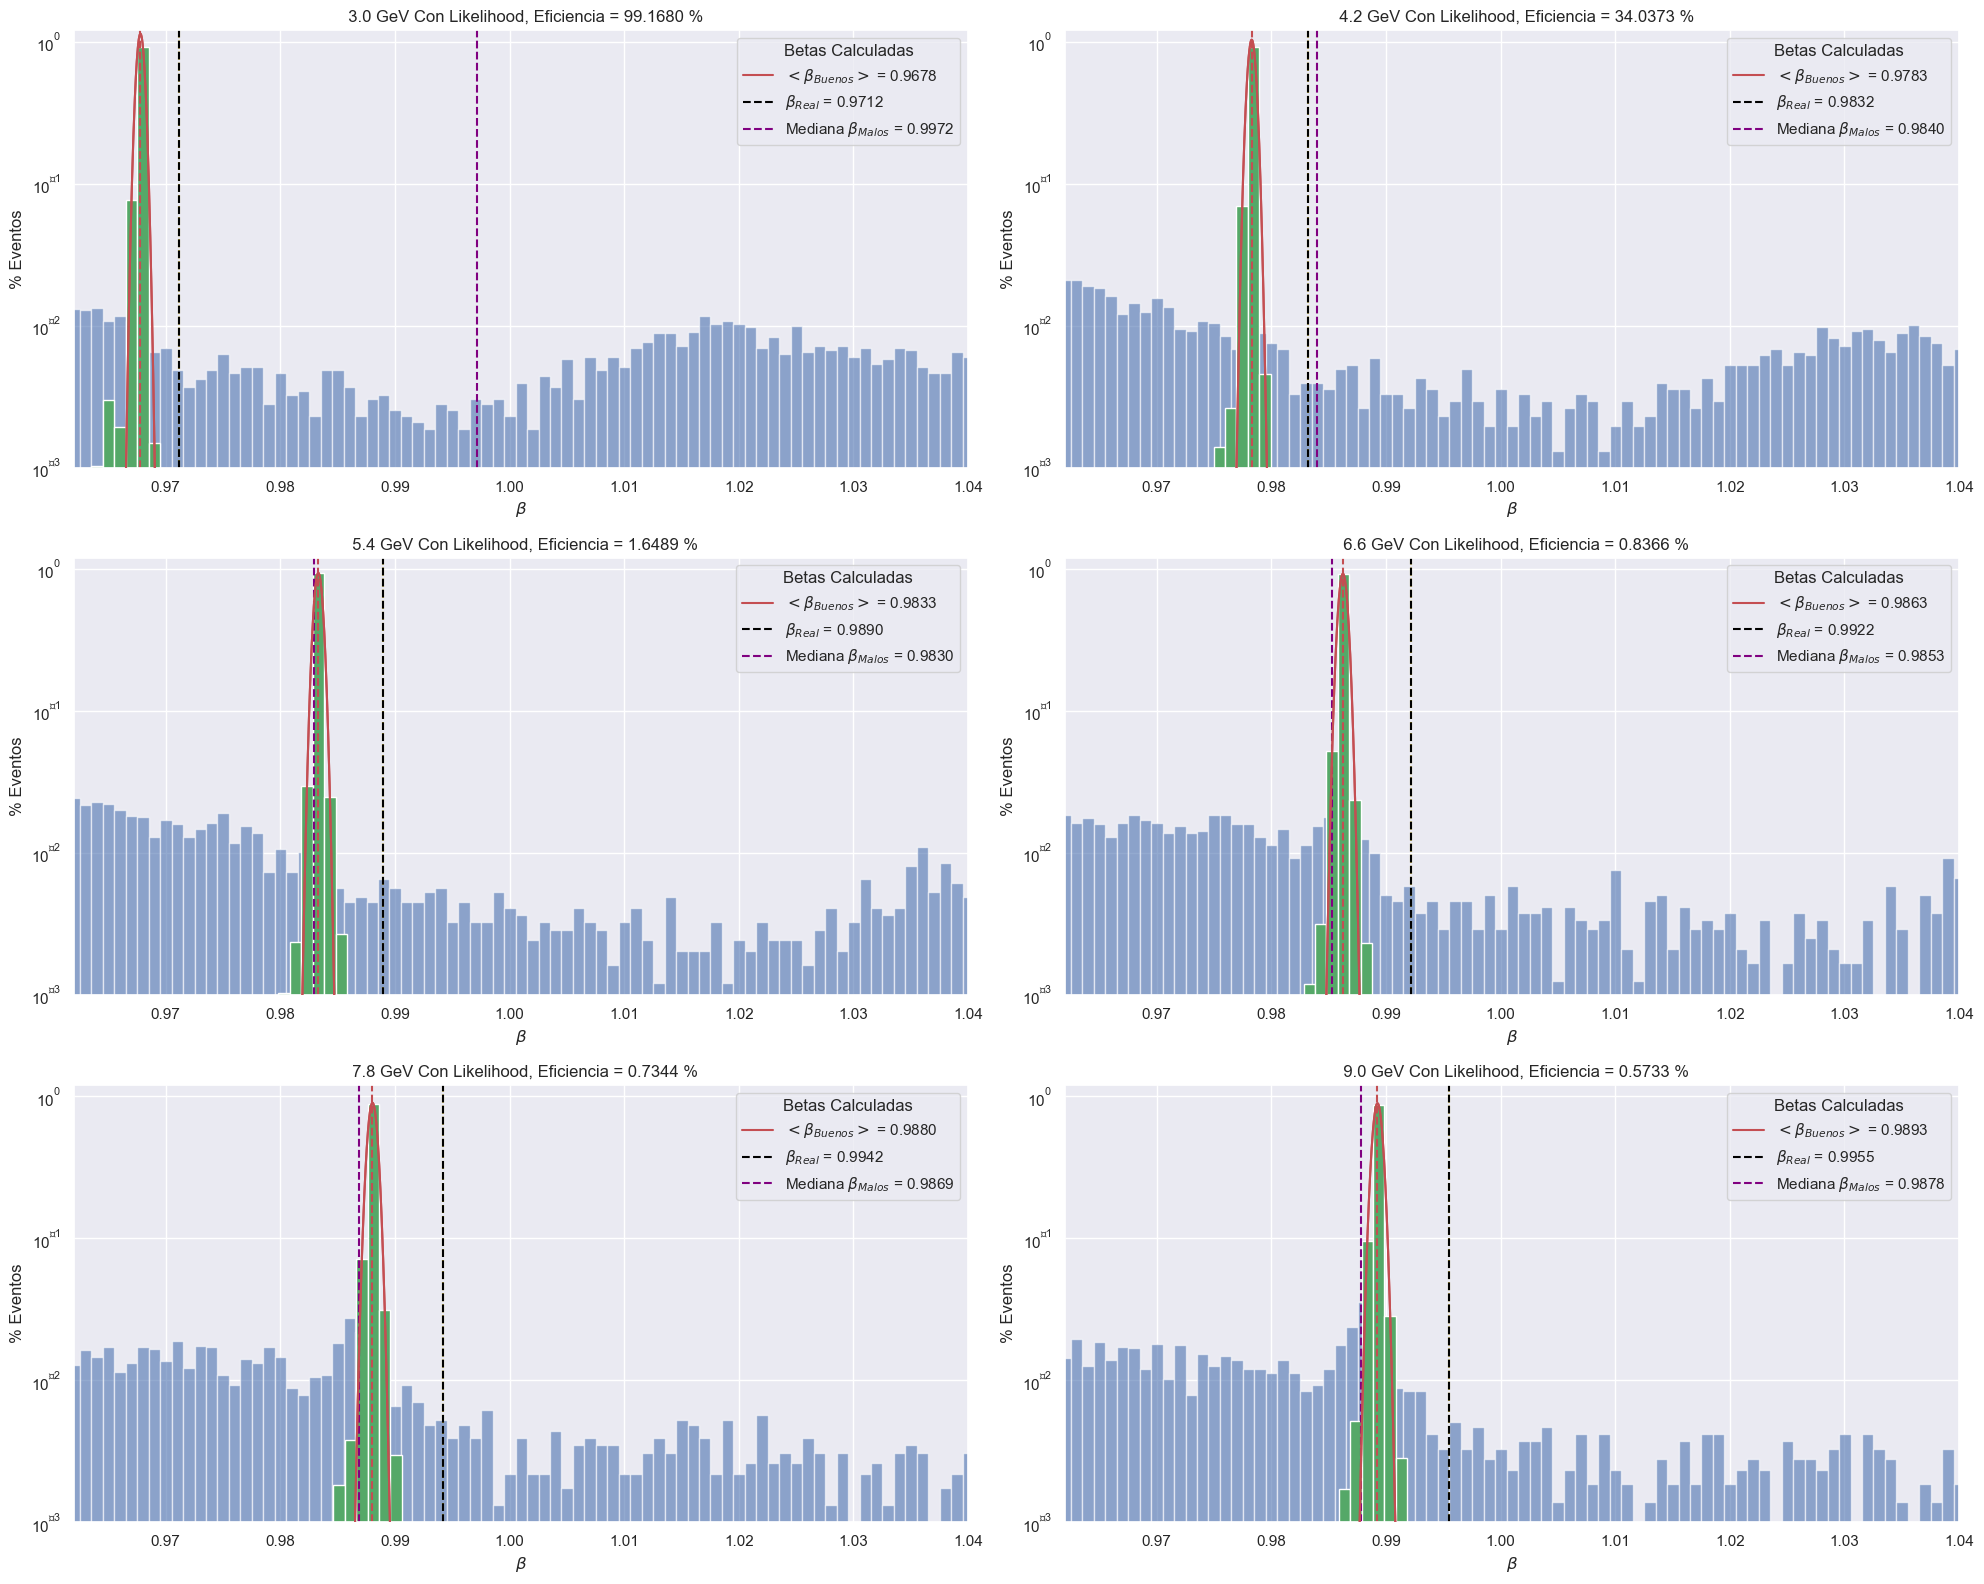

In [4]:
from scipy.optimize import curve_fit

def gaussian(x, a, b, c):
    return a * np.exp(-(x - b)**2 / (2 * c**2))

enes = [3.0, 4.2, 5.4, 6.6, 7.8, 9.0]

fig, axs = plt.subplots(3, 2, figsize=(20, 16))
efficiencies = []

for idx, ene in enumerate(enes):
    ene_str = str(ene).replace('.', '_')
    ax = axs[idx//2, idx%2]
    good_files = [f'9cm/csv/df{ene_str}_good{i}.csv' for i in (1,3)]
    bad_files = [f'9cm/csv/df{ene_str}_bad{i}.csv' for i in (1,3)]
    df_good = pd.concat([pd.read_csv(f) for f in good_files])
    df_bad = pd.concat([pd.read_csv(f) for f in bad_files])

    df_good_grouped = df_good.groupby('eventNumber').first()
    df_bad_grouped = df_bad.groupby('eventNumber').first()

    bin_width = 0.001

    bins_good = np.arange(min(df_good_grouped["beta_hat"]), max(df_good_grouped["beta_hat"]) + bin_width, bin_width)
    counts_good, _ = np.histogram(df_good_grouped["beta_hat"], bins=bins_good)
    bins_bad = np.arange(min(df_bad_grouped["beta_hat"]), max(df_bad_grouped["beta_hat"]) + bin_width, bin_width)
    counts_bad, _ = np.histogram(df_bad_grouped["beta_hat"], bins=bins_bad)
    counts_good = counts_good / np.sum(counts_good)
    counts_bad = counts_bad / np.sum(counts_bad)

    bin_centers_good = (bins_good[:-1] + bins_good[1:]) / 2
    bin_centers_bad = (bins_bad[:-1] + bins_bad[1:]) / 2 

    ax.bar(bin_centers_good, counts_good, width=np.diff(bins_good), color='g', alpha=1, zorder=2)

    initial_guess_good = [max(counts_good), bin_centers_good[np.argmax(counts_good)], np.std(df_good_grouped["beta_hat"])]
    popt_good, _ = curve_fit(gaussian, bin_centers_good, counts_good, p0=initial_guess_good, maxfev=5000)
    x_good = np.linspace(min(bin_centers_good), max(bin_centers_good), 1000)
    ax.plot(x_good, gaussian(x_good, *popt_good), 'r-', zorder=3)
    ax.axvline(popt_good[1], color='r', linestyle='--')
    ax.bar(bin_centers_bad, counts_bad, width=np.diff(bins_bad), color='b', alpha=0.6, zorder=1)

    beta_r = calculate_beta_proton(ene)
    ax.axvline(beta_r, color='gold', linestyle='--')

    ax.set_xlim([0.962, 1.04])
    ax.set_ylim([1e-3, 1.2])

    ax.set_yscale('log')

    ax.set_xlabel(r'$\beta$')
    ax.set_ylabel('% Eventos')

    line_good, = ax.plot(x_good, gaussian(x_good, *popt_good), 'r-', zorder=3) 

    line_beta_r = ax.axvline(beta_r, color='black', linestyle='--')

    lower_bound = beta_r - 0.005*beta_r
    upper_bound = beta_r + 0.005*beta_r

    num_events_in_range = df_good_grouped[(df_good_grouped["beta_hat"] >= lower_bound) & (df_good_grouped["beta_hat"] <= upper_bound)].shape[0]

    total_events = df_good_grouped.shape[0]
    efficiency = num_events_in_range / total_events
    efficiencies.append(efficiency)

    median_bad = df_bad_grouped["beta_hat"].median()
    line_median_bad = ax.axvline(median_bad, color='purple', linestyle='--')

    ax.legend([line_good, line_beta_r, line_median_bad], 
              [f'$<\\beta_{{Buenos}}>$ = {popt_good[1]:.4f}', 
               f'$\\beta_{{Real}}$ = {beta_r:.4f}', 
               f'Mediana $\\beta_{{Malos}}$ = {median_bad:.4f}'], 
              title='Betas Calculadas')

    ax.set_title(f'  {str(ene)} GeV Con Likelihood, Eficiencia = {efficiency*100:.4f} %')

fig.tight_layout()
fig.savefig(f"./figures/pLike9.png")

plt.show()

In [ ]:
"""import matplotlib.pyplot as plt
import numpy as np

def draw_circle(ax, centerX, centerY, radius, color):
    circle = plt.Circle((centerX, centerY), radius, fill=False, color=color)
    ax.add_artist(circle)
    ax.plot(centerX, centerY, marker='o', color=color)  # plot the center
    
# Assuming good_events and bad_events are DataFrames grouped by 'eventNumber'
good_events = df_good.groupby('eventNumber')
bad_events = df_bad.groupby('eventNumber')

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot for df_good
for i, (eventNumber, event) in enumerate(good_events):
    if i > 1:  # Limit the number of plots to the size of the axs array
        break
    axs[0, i].scatter(event.detectorPositionX, event.detectorPositionY, color='blue')
    draw_circle(axs[0, i], event.centerX.mean(), event.centerY.mean(), event.radius.mean(), 'magenta')

# Plot for df_bad
for i, (eventNumber, event) in enumerate(bad_events):
    if i > 1:  # Limit the number of plots to the size of the axs array
        break
    axs[1, i].scatter(event.detectorPositionX, event.detectorPositionY, color='yellow')
    draw_circle(axs[1, i], event.centerX.mean(), event.centerY.mean(), event.radius.mean(), 'cyan')

plt.show()"""

"import matplotlib.pyplot as plt\nimport numpy as np\n\ndef draw_circle(ax, centerX, centerY, radius, color):\n    circle = plt.Circle((centerX, centerY), radius, fill=False, color=color)\n    ax.add_artist(circle)\n    ax.plot(centerX, centerY, marker='o', color=color)  # plot the center\n    \n# Assuming good_events and bad_events are DataFrames grouped by 'eventNumber'\ngood_events = df_good.groupby('eventNumber')\nbad_events = df_bad.groupby('eventNumber')\n\nfig, axs = plt.subplots(2, 2, figsize=(10, 10))\n\n# Plot for df_good\nfor i, (eventNumber, event) in enumerate(good_events):\n    if i > 1:  # Limit the number of plots to the size of the axs array\n        break\n    axs[0, i].scatter(event.detectorPositionX, event.detectorPositionY, color='blue')\n    draw_circle(axs[0, i], event.centerX.mean(), event.centerY.mean(), event.radius.mean(), 'magenta')\n\n# Plot for df_bad\nfor i, (eventNumber, event) in enumerate(bad_events):\n    if i > 1:  # Limit the number of plots to the 

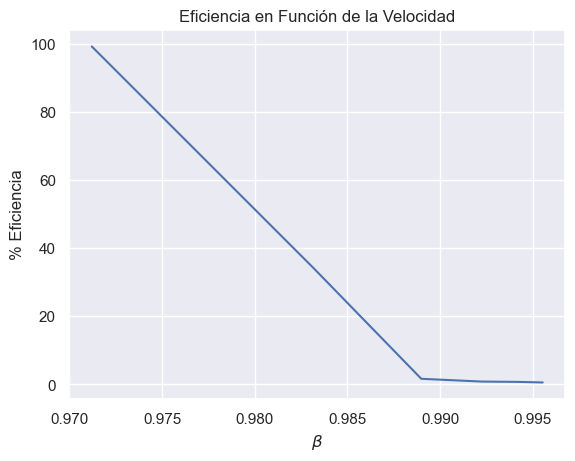

In [10]:
betas = [calculate_beta_proton(ene) for ene in enes]

plt.title("Eficiencia en Función de la Velocidad")

plt.xlabel(r'$\beta$')
plt.ylabel("% Eficiencia")

plt.plot(betas, [efe*100 for efe in efficiencies])